# DrivenData Competition

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

tf.__version__

'2.4.1'

# Getting the data ready

In [4]:
train_x = pd.read_csv('train_values.csv')
train_x.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_y = pd.read_csv('train_labels.csv')
train_y.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [6]:
## to_encode = train_x.columns[8:15]

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [8]:
def label_encode(df):
    for column in df.columns:
        if df[column].dtype =='object':
            df[column] = le.fit_transform(df[column])

In [9]:
train_x.dtypes.unique()

array([dtype('int64'), dtype('O')], dtype=object)

In [10]:
def preptrain(df):
    df['geo_level_2_id'] = (df['geo_level_2_id'] - df['geo_level_2_id'].mean()) / df['geo_level_2_id'].std()
    df['geo_level_3_id'] = (df['geo_level_3_id'] - df['geo_level_3_id'].mean()) / df['geo_level_3_id'].std()
    df.legal_ownership_status = le.fit_transform(df.legal_ownership_status)
    label_encode(df)
    df.drop('building_id', inplace = True, axis = 1)

In [11]:
preptrain(train_x)

In [12]:
train_y.drop('building_id', inplace = True, axis = 1)

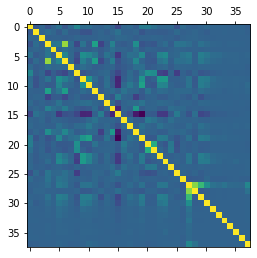

In [13]:
import matplotlib.pyplot as plt
plt.matshow(train_x.corr())
plt.show()

<AxesSubplot:>

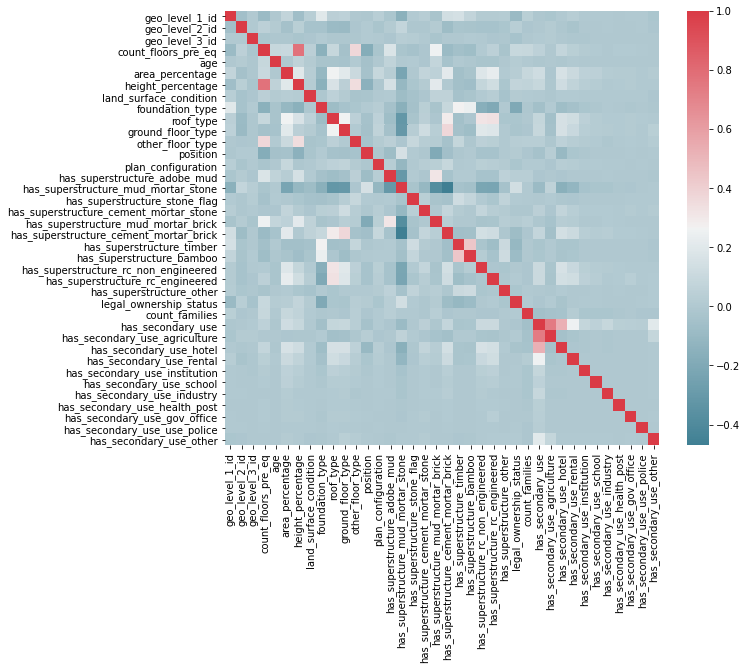

In [14]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = train_x.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Model ---> TensorFlow Dense, RandomForestClassifier

In [15]:
epochs = 20
batch_size = 128

In [16]:
from sklearn.svm import SVC
def xg_boost_hackathon(data, target):
    model = SVC()
    model.fit(data, target)
    return model

In [ ]:
model = xg_boost_hackathon(train_x, train_y)

/home/pc/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
act = tf.nn.leaky_relu
model = Sequential([
    Dense(512, activation=act),
    Dropout(0.2),
    Dense(256, activation=act,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(128, activation=act),
    Dense(5, activation='softmax')
])

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
act = tf.nn.leaky_relu
model = Sequential([
    Dense(1024, activation=act,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation=act,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation=act,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32),
    Dense(5, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopper = EarlyStopping(monitor = 'accuracy', patience=2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2)
history = model.fit(train_x, train_y, validation_split=0.1, shuffle=True, callbacks = [early_stopper, reduce_lr], verbose=1, epochs = epochs, batch_size = batch_size)

In [ ]:
sub = pd.read_csv('submission_format.csv')
sub.tail()

In [ ]:
test_x = pd.read_csv('test_values.csv')
test_x.tail()

In [ ]:
preptrain(test_x)
test_x.head()

In [ ]:
predictions = model.predict(test_x)
type(predictions)

In [ ]:
ss = []
for k in predictions:
    s = max(k)
    for i in range(len(k)):
        if s == k[i]:
            ss.append(i)

In [ ]:
sub['damage_grade'] = ss

In [ ]:
sub['damage_grade'] = sub['damage_grade'].astype('int')
sub.to_csv('submission.csv', index = False)